# Convergence of (linear/non-linear) one-dimensional convnets with normalization

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from include.onedim import *

from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = False
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


## Standard initialization

In [5]:
n = 16
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

## Fitting a linear network with normalization

input shape:  [1, 1, 16]
optimize with SGD 0.1


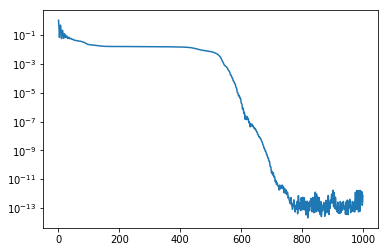

Error: 1.3907263e-06


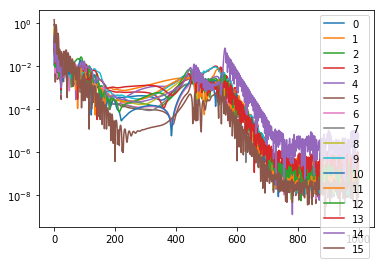

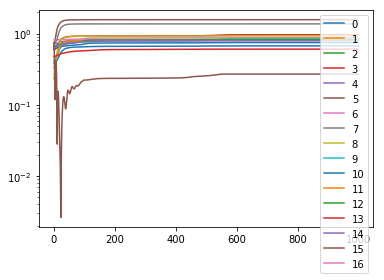

In [6]:
num_channels = [1]*15
net = decnet(1,num_channels,3,act_fun=None,mode="non-learned",res=False).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.1)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

## Fitting a linear network without normalization

input shape:  [1, 1, 16]
optimize with SGD 0.1


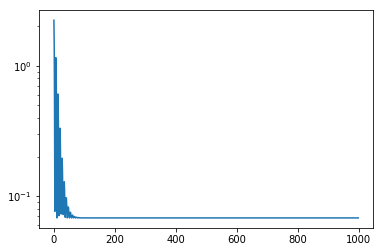

Error: 0.44388917


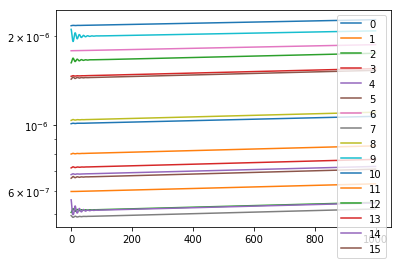

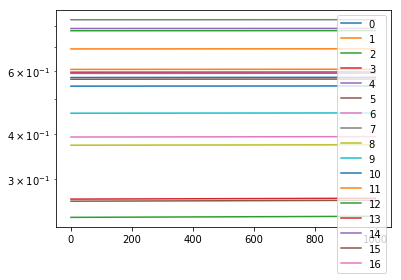

In [8]:
num_channels = [1]*15
net = decnet(1,num_channels,3,act_fun=None,mode="linear",res=False).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.1)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

## Fitting with centering

input shape:  [1, 1, 16]
optimize with SGD 0.1


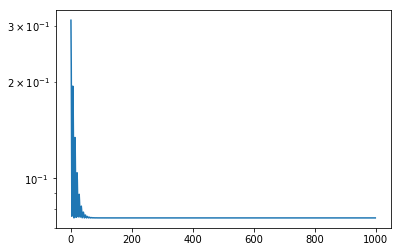

Error: 0.46753868


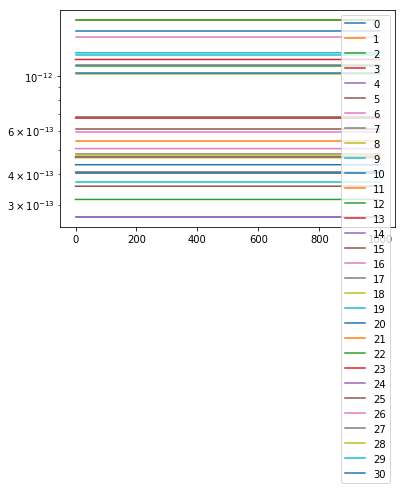

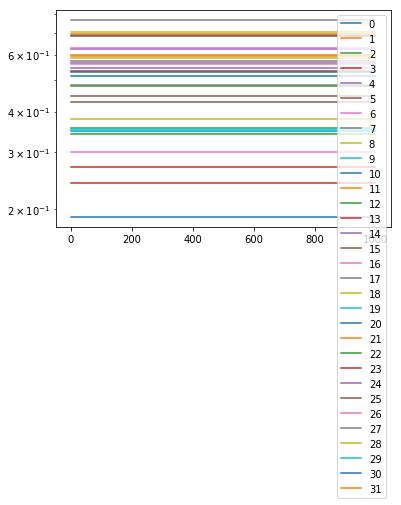

In [15]:
num_channels = [1]*30
net = decnet(1,num_channels,3,act_fun=None,res=False, mode="linear"#, modeout="normalize"
            ).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.1)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

input shape:  [1, 1, 16]
optimize with SGD 0.1


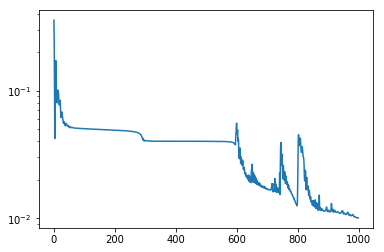

Error: 0.17071259


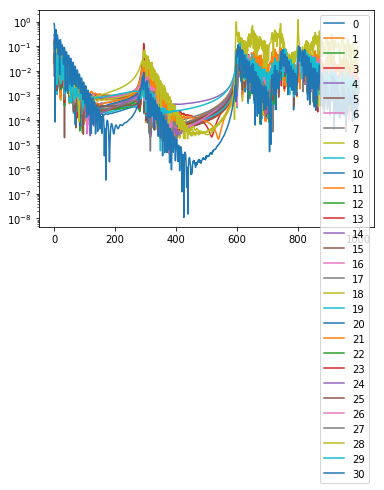

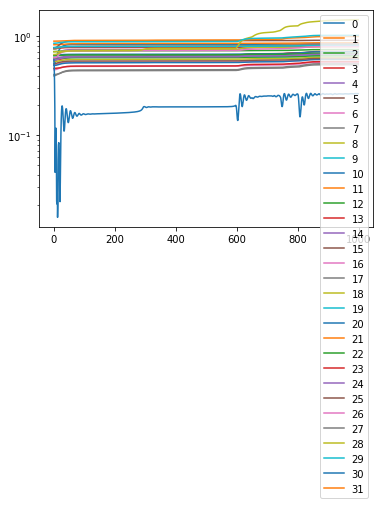

In [16]:
num_channels = [1]*30
net = decnet(1,num_channels,3,act_fun=None,res=False, mode="center", modeout="normalize").type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.1)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

# Res net

## linear 

input shape:  [1, 1, 16]
optimize with SGD 0.01


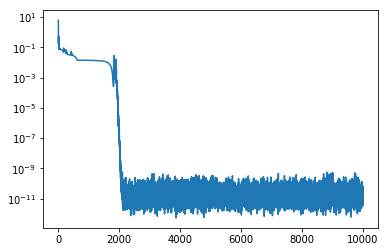

Error: 1.7029863e-05
Error: 1.7029863e-05


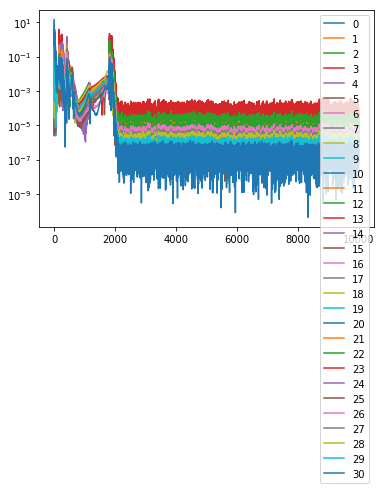

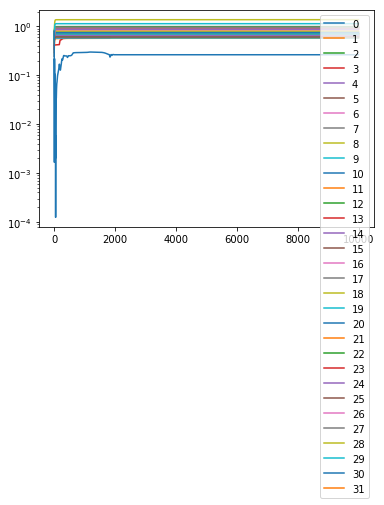

In [17]:
num_channels = [1]*30
net = decnet(1,num_channels,3,None,mode="linear",res=True).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 10000,LR = 0.01)

yy = net(ni).type(dtype)
yy_np = yy.data.cpu().numpy()[0,0]

plt.semilogy(mse)
plt.show()

print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

## BN

input shape:  [1, 1, 16]
optimize with SGD 0.01


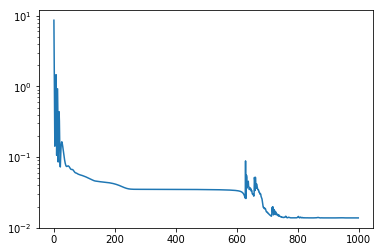

Error: 0.2003557
Error: 0.2003557


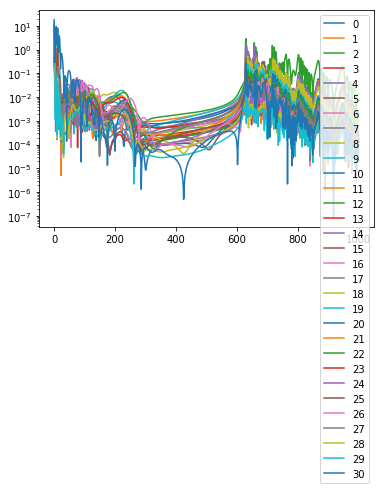

In [18]:
num_channels = [1]*30
net = decnet(1,num_channels,3,None,mode="non-learned",res=True).type(dtype)

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.01)

yy = net(ni).type(dtype)
yy_np = yy.data.cpu().numpy()[0,0]

plt.semilogy(mse)
plt.show()

print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)

# Highly overparameterized

In [19]:
n = 15
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

input shape:  [1, 1, 15]
optimize with SGD 0.01


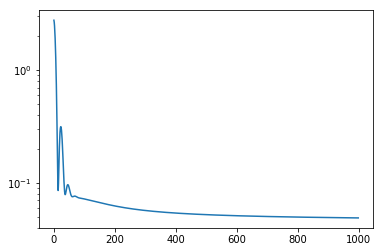

Error: 0.3970599


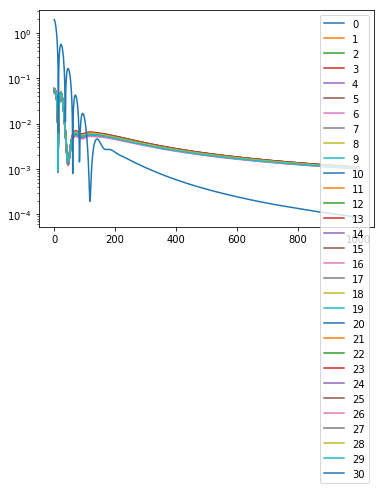

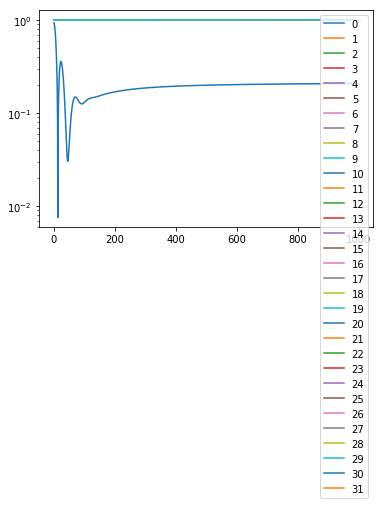

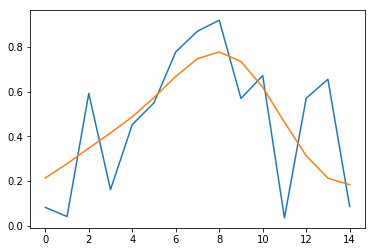

In [20]:
def uniform_initialize(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            if m.weight.data.shape[2]>1:
                m.weight.data.uniform_()
                m.weight.data *= 0.1
                #m.weight.data[0,0,0] = 0
                m.weight.data[0,0,1] = 1
                #m.weight.data[0,0,2] = 0
                #m.weight.data[0,0,3] = 0
                #m.weight.data[0,0,4] = 0
                
num_channels = [1]*30
#net = decnet(1,num_channels,51,act_fun=None,res=False, mode="normalize", modeout="normalize").type(dtype)
net = decnet(1,num_channels,3,act_fun=None,res=False, mode= "non-learned",modeout="none").type(dtype)
net.apply( uniform_initialize )

mse, ni, net, out_grads, out_norms = fit(net,y,num_channels,net_input = None,num_iter = 1000,LR = 0.01)

plt.semilogy(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)
plot_gradients(out_norms)

plt.plot(y_np)
plt.plot(yy_np)
plt.show()

In [21]:
print(net)

Sequential(
  (1): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (2): ChannelNormalization()
  (3): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (4): ChannelNormalization()
  (5): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (6): ChannelNormalization()
  (7): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (8): ChannelNormalization()
  (9): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (10): ChannelNormalization()
  (11): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (12): ChannelNormalization()
  (13): Sequential(
    (0): Pad1d()
    (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), bias=False)
  )
  (14): ChannelNormalization()
  (15): Sequential(
    (0): Pad1d()
 